In [45]:
"""
A plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.
"""

'\nA plot of samples drawn from a mixture of 3 Gaussians, with unit variance and significantly different means.\n'

In [46]:
# This allows you to edit.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from src.smalldiffusion.model import TimeInputMLP
from src.smalldiffusion.diffusion import ScheduleLogLinear, training_loop, samples
from animations import animate_diffusion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch, filename, save=False):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

    if save:
        # Save the plot to the specified path
        plt.savefig(filename)
    
    # Close the plot to free up memory
    plt.close()

In [48]:
# Define mean and variance, where the variance is unit and the means are significantly different.
mean_1 = 0.0
variance_1 = 1.0

mean_2 = 20
variance_2 = 1.0

mean_3 = -20
variance_3 = 1.0

In [49]:
# Generate samples
samples_group_1 = np.random.normal(loc=mean_1, scale=variance_1**0.5, size=20)  
samples_group_2 = np.random.normal(loc=mean_2, scale=variance_2**0.5, size=20)  
samples_group_3 = np.random.normal(loc=mean_3, scale=variance_3**0.5, size=20)  

# concatenate them
samples_combined = []
samples_combined.extend(samples_group_1)
samples_combined.extend(samples_group_2)
samples_combined.extend(samples_group_3)

In [50]:
print(len(samples_combined))
print(samples_group_1)
print(samples_group_2)
print(samples_group_3)

60
[ 0.58169457 -0.7510344   1.74456901 -1.43747662 -1.36084762  1.72381246
  0.58745027  0.34980242 -1.1210248   2.10202348  1.11713568  0.83599492
  1.50495203  0.08283851  0.43112241 -0.99396104 -0.42868464  3.40192502
 -1.28561694  1.85928261]
[18.85893221 19.51400632 20.12843607 19.48583616 19.20171319 21.39984065
 20.35561399 20.74277692 21.1245575  18.82988447 21.58093433 20.84910953
 21.1263893  18.47371625 20.92810412 21.61849387 19.96487631 20.23379978
 19.01695675 19.35315295]
[-19.76335276 -21.39728938 -20.08335735 -20.29496741 -21.35742833
 -18.0006345  -19.61311531 -20.40740463 -20.27494169 -18.78674421
 -21.78412802 -19.6952035  -19.32412106 -20.21977587 -20.61162996
 -19.55198298 -19.74103508 -21.80279028 -20.91301443 -18.71058828]


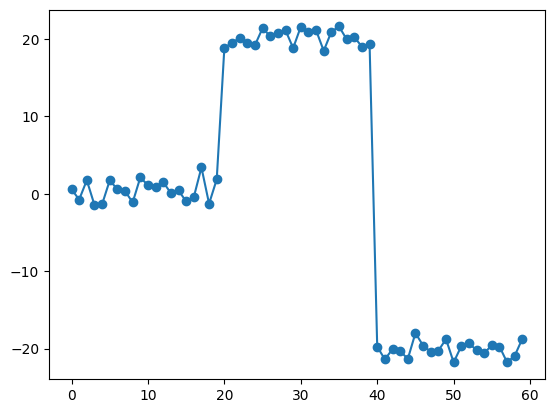

In [51]:
# Plot the values
plt.plot(samples_combined, marker='o')

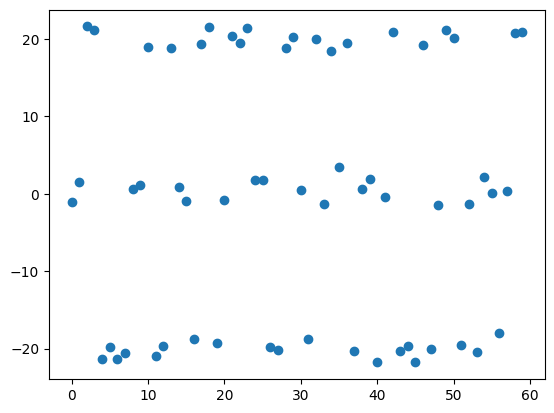

In [52]:
# Shuffle the list
shuffled_list = random.sample(samples_combined, len(samples_combined))

# Generate corresponding x-values
x_values = list(range(len(samples_combined)))

# Plot the values as points
plt.scatter(x_values, shuffled_list)

In [53]:
class GaussDistribution2D(Dataset):
    def __init__(self, mean, covariance_matrix, num_samples):

        # Sample from 3 different distributions
        samples_1 = np.random.multivariate_normal(mean[0], covariance_matrix, num_samples//3)
        samples_2 = np.random.multivariate_normal(mean[1], covariance_matrix, num_samples//3)
        samples_3 = np.random.multivariate_normal(mean[2], covariance_matrix, num_samples//3)

        samples_combined = []
        samples_combined.extend(samples_1)
        samples_combined.extend(samples_2)
        samples_combined.extend(samples_3)

        self.vals = samples_combined
        print((samples_combined))

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]
    

In [54]:
mean = [[0,0], [20,20], [-20,-20]]
covariance_matrix = [[1.0, 0.0], [0.0, 1.0]]  # Zero covariance
num_samples = 100
dataset = GaussDistribution2D(mean, covariance_matrix, num_samples)

loader = DataLoader(dataset, batch_size=2048)

[array([-0.83054112, -1.2613826 ]), array([-2.40884662,  0.12624071]), array([-0.38527363, -0.40451014]), array([ 0.74415404, -1.52510648]), array([0.99252396, 1.19865523]), array([ 1.13057185, -1.42962832]), array([-1.9674356 ,  0.24703338]), array([ 1.02504397, -1.50936598]), array([-0.83419339, -0.68934273]), array([-0.16546946,  1.15135834]), array([-2.70357967, -0.68688829]), array([-1.39947975, -0.03878682]), array([ 2.24005441, -2.33819824]), array([-1.63811588, -2.36146698]), array([-0.36330556, -0.26804911]), array([0.28831311, 0.11515708]), array([1.19173481, 1.64244522]), array([-1.47637382,  0.7541754 ]), array([ 0.77410509, -1.62501224]), array([-1.3875851 , -1.36684288]), array([ 0.30230393, -0.49260926]), array([0.31717607, 0.13183329]), array([ 0.23268927, -1.43243887]), array([-1.02576511,  0.01006948]), array([-0.57806362,  0.10131716]), array([-0.82066025,  0.79685374]), array([ 0.49572329, -0.90277976]), array([ 0.3452876 , -0.97247933]), array([0.19339674, 2.001201

In [55]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2816384/3622150299.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


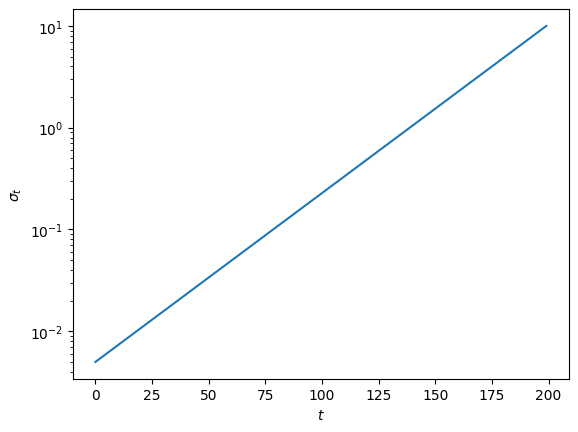

In [56]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process

schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2816384/2044932982.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_2816384/2044932982.py:20: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


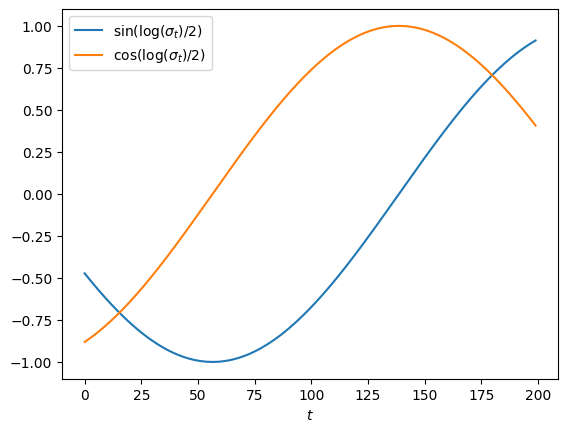

In [57]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""

# schedule.sigmas is essentially 1D. however, get_sigma_embeds takes it to 2D
# where the first D is "torch.sin(torch.log(sigma)/2)" and the second D is "torch.cos(torch.log(sigma)/2)"
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [62]:
trainer  = training_loop(loader, model, schedule, epochs=15000)
losses   = [ns.loss.item() for ns in trainer]

  0%|          | 0/15000 [00:00<?, ?it/s]

torch.float64 torch.float64 torch.float64


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
print(len(loader))
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

1


NameError: name 'losses' is not defined

In [59]:
# all the instances in the data combined (plotted) together results
# in this 3 Gaussian shape. This is essentially the noiseless data that 
# represents the dataset
plot_batch(next(iter(loader)), filename="Gauss3", save=True)

In [60]:
# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0


xt = samples(model, schedule.sample_sigmas(250), mu=0.5, batchsize=1500)
# convert it to a list
denoising_steps = list(xt)
plot_batch(denoising_steps[249], filename="Gauss3_DDPM_250", save=True)


pairwise(sigmas):  <itertools.pairwise object at 0x7ae9e8ee4040>
enumerate(pairwise(sigmas)):  [(0, (tensor(10.), tensor(9.6252))), (1, (tensor(9.6252), tensor(9.2645))), (2, (tensor(9.2645), tensor(9.2645))), (3, (tensor(9.2645), tensor(8.9173))), (4, (tensor(8.9173), tensor(8.5832))), (5, (tensor(8.5832), tensor(8.2615))), (6, (tensor(8.2615), tensor(7.9519))), (7, (tensor(7.9519), tensor(7.9519))), (8, (tensor(7.9519), tensor(7.6539))), (9, (tensor(7.6539), tensor(7.3671))), (10, (tensor(7.3671), tensor(7.0910))), (11, (tensor(7.0910), tensor(6.8253))), (12, (tensor(6.8253), tensor(6.8253))), (13, (tensor(6.8253), tensor(6.5695))), (14, (tensor(6.5695), tensor(6.3233))), (15, (tensor(6.3233), tensor(6.0863))), (16, (tensor(6.0863), tensor(5.8582))), (17, (tensor(5.8582), tensor(5.8582))), (18, (tensor(5.8582), tensor(5.6387))), (19, (tensor(5.6387), tensor(5.4274))), (20, (tensor(5.4274), tensor(5.2240))), (21, (tensor(5.2240), tensor(5.0282))), (22, (tensor(5.0282), tensor(5.0282))

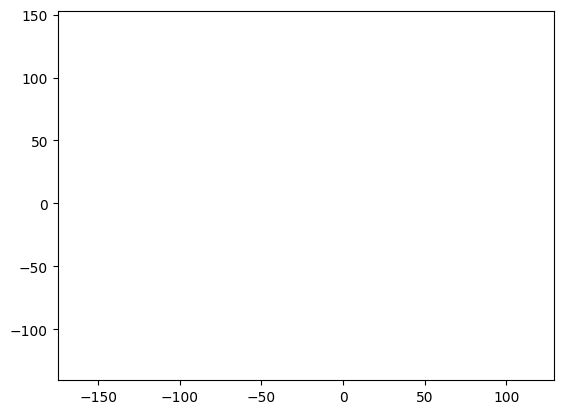

In [61]:
animate_diffusion(denoising_steps, filename="Gauss3_DDPM_250", save=True)